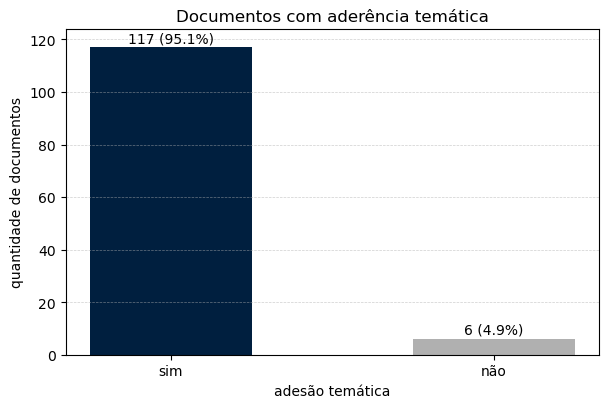

,file_name,source_path,a_hits,b_hits,window_hits,short_flag,n_tokens,raw_score,is_thematic,timestamp
0,a_002.txt,/Users/cibelealexandreu/Documents/jurimetria_a...,47,455,1,0,32665,1437.5,True,2025-11-01T02:27:54.340334
1,a_003.txt,/Users/cibelealexandreu/Documents/jurimetria_a...,122,337,1,0,25714,1196.0,True,2025-11-01T02:27:54.371788
2,a_004.txt,/Users/cibelealexandreu/Documents/jurimetria_a...,53,481,1,0,33478,1524.5,True,2025-11-01T02:27:54.412801
3,a_005.txt,/Users/cibelealexandreu/Documents/jurimetria_a...,46,464,1,0,32957,1463.0,True,2025-11-01T02:27:54.452487
4,a_006.txt,/Users/cibelealexandreu/Documents/jurimetria_a...,70,517,1,0,40359,1658.0,True,2025-11-01T02:27:54.500805
...,...,...,...,...,...,...,...,...,...,...
118,a_125.txt,/Users/cibelealexandreu/Documents/jurimetria_a...,83,388,1,0,32498,1290.5,True,2025-11-01T02:27:59.667610
119,a_126.txt,/Users/cibelealexandreu/Documents/jurimetria_a...,116,553,1,0,53585,1835.0,True,2025-11-01T02:27:59.730547
120,a_127.txt,/Users/cibelealexandreu/Documents/jurimetria_a...,2219,4008,1,0,544638,15354.5,True,2025-11-01T02:28:00.368000
121,a_128.txt,/Users/cibelealexandreu/Documents/jurimetria_a...,83,437,1,0,35021,1437.5,True,2025-11-01T02:28:00.414216


In [1]:
from pathlib import Path
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import shutil

config_path = (
    Path.home()
    / "Documents"
    / "jurimetria_aved_stf"
    / "config"
    / "project_config.json"
)
config = json.loads(config_path.read_text(encoding="utf-8"))

clean_dir    = Path(config["paths"]["corpus_clean_dir"]).expanduser()
thematic_dir = Path(config["paths"]["thematic_dir"]).expanduser()
ranked_dir   = Path(config["paths"]["ranked_dir"]).expanduser()
logs_dir     = Path(config["paths"]["logs_dir"]).expanduser()
figures_dir  = Path(config["paths"]["figures_dir"]).expanduser()
raw_pdf_dir  = Path(config["paths"]["raw_pdf_dir"]).expanduser()
project_root = Path(config["paths"]["project_root"]).expanduser()

thematic_dir.mkdir(parents=True, exist_ok=True)
ranked_dir.mkdir(parents=True, exist_ok=True)
logs_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

thematic_pdfs_dir = project_root / "data" / "03_thematic_pdfs"
thematic_pdfs_dir.mkdir(parents=True, exist_ok=True)

group_a_patterns = [
    "fake", "fake_news",
    "conteudo", "conteudo_falso", "conteudo_enganoso",
    "desinform", "misinform", "desordem",
    "narrativ", "fraude", "urna", "tse",
    "milicia", "milicias", "milicias_digitais",
    "gabinete", "gabinete_do_odio", "digital",
    "telegram", "whatsapp",
    "convoc", "caravana",
    "financi", "incentiv", "incit",
    "rede_social", "redes_sociais", "rede", "social",
    "perfil", "plataforma",
    "qg", "quartel", "quartel_general",
]

group_b_patterns = [
    "8_de_janeiro", "8_de_janeiro_de_2023",
    "ato_antidemocratico", "atos_antidemocraticos", "antidemocrat",
    "invasao", "invasao_de_brasilia", "brasilia",
    "depred", "destruic", "vandalismo", "patrimonio",
    "praca_dos_tres_poderes", "praça_dos_três_poderes",
    "palacio_do_planalto", "planalto",
    "congresso_nacional", "congresso",
    "supremo_tribunal_federal", "stf",
    "quebra_da_ordem_democratica", "ordem_democratica",
    "golpe", "golpe_de_estado",
    "acamp", "acampamento", "acampamento_em_frente",
    "tomar_os_tres_poderes", "tomar os tres poderes",
]

WINDOW_TOKENS    = 40
STRONG_A_HITS    = 3
STRONG_B_HITS    = 2
SHORT_DOC_TOKENS = 120

def is_a(tok: str) -> bool:
    tok = tok.lower()
    for pat in group_a_patterns:
        if pat in tok:
            return True
    return False

def is_b(tok: str) -> bool:
    tok = tok.lower()
    for pat in group_b_patterns:
        if pat in tok:
            return True
    return False

records = []
txt_files = sorted(clean_dir.glob("*.txt"))

for txt_path in txt_files:
    text = txt_path.read_text(encoding="utf-8", errors="ignore")
    lowered = text.lower().strip()

    if not lowered:
        records.append(
            {
                "file_name": txt_path.name,
                "source_path": str(txt_path),
                "a_hits": 0,
                "b_hits": 0,
                "window_hits": 0,
                "short_flag": 0,
                "n_tokens": 0,
                "raw_score": 0.0,
                "is_thematic": False,
                "timestamp": datetime.utcnow().isoformat(),
            }
        )
        continue

    tokens = lowered.split()
    n_tokens = len(tokens)

    idx_a = [i for i, t in enumerate(tokens) if is_a(t)]
    idx_b = [i for i, t in enumerate(tokens) if is_b(t)]

    a_hits = len(idx_a)
    b_hits = len(idx_b)

    window_hits = 0
    if idx_a and idx_b:
        for ia in idx_a:
            start = max(0, ia - WINDOW_TOKENS)
            end   = min(len(tokens), ia + WINDOW_TOKENS + 1)
            window = tokens[start:end]
            has_a = any(is_a(t) for t in window)
            has_b = any(is_b(t) for t in window)
            if has_a and has_b:
                window_hits = 1
                break

    short_flag = 1 if n_tokens <= SHORT_DOC_TOKENS else 0

    raw_score = (
        3.0 * b_hits +
        2.0 * window_hits +
        1.5 * a_hits +
        1.0 * short_flag
    )

    records.append(
        {
            "file_name": txt_path.name,
            "source_path": str(txt_path),
            "a_hits": a_hits,
            "b_hits": b_hits,
            "window_hits": window_hits,
            "short_flag": short_flag,
            "n_tokens": n_tokens,
            "raw_score": raw_score,
            "is_thematic": False,
            "timestamp": datetime.utcnow().isoformat(),
        }
    )

df = pd.DataFrame(records)

df_sorted = df.sort_values(by="raw_score", ascending=False).reset_index(drop=True)
scores = df_sorted["raw_score"].tolist()

if not scores:
    threshold = 1
else:
    if max(scores) == min(scores):
        threshold = 1 if max(scores) == 0 else scores[0]
    else:
        drops = []
        for i in range(1, len(scores)):
            prev = scores[i - 1]
            cur  = scores[i]
            diff = prev - cur
            rel  = diff / prev if prev else diff
            drops.append((i, rel, prev, cur))
        drops = [d for d in drops if d[0] >= 3]
        if not drops:
            threshold = scores[-1]
        else:
            drops.sort(key=lambda x: x[1], reverse=True)
            elbow_idx, _, elbow_prev, _ = drops[0]
            threshold = elbow_prev

df["is_thematic"] = df["raw_score"] >= threshold

for row in df.itertuples():
    if row.is_thematic:
        src_txt = clean_dir / row.file_name
        dst_txt = thematic_dir / row.file_name
        if src_txt.exists():
            dst_txt.write_text(src_txt.read_text(encoding="utf-8"), encoding="utf-8")

        pdf_name = Path(row.file_name).with_suffix(".pdf").name
        src_pdf = raw_pdf_dir / pdf_name
        if src_pdf.exists():
            shutil.copy2(src_pdf, thematic_pdfs_dir / pdf_name)

df.sort_values(
    by=["is_thematic", "raw_score", "file_name"],
    ascending=[False, False, True]
).to_csv(logs_dir / "thematic_log.csv", index=False)

df.to_csv(ranked_dir / "thematic_scores.csv", index=False)

total_docs = len(df)
yes_count  = int(df["is_thematic"].sum())
no_count   = total_docs - yes_count

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(
    ["sim", "não"],
    [yes_count, no_count],
    color=["#001f3f", "#b0b0b0"],
    width=0.5
)

ax.set_title("Documentos com aderência temática")
ax.set_ylabel("quantidade de documentos")
ax.set_xlabel("adesão temática")

max_val = max(yes_count, no_count) if total_docs else 0
margin  = 1 if max_val == 0 else max(1, int(max_val * 0.05))
upper   = max_val + margin + 1.8

ax.set_ylim(0, upper)
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)

for bar, val in zip(bars, [yes_count, no_count]):
    pct = (val / total_docs) * 100 if total_docs else 0.0
    y_text = val + (margin * 0.15)
    if y_text > upper - 0.15:
        y_text = upper - 0.15
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        y_text,
        f"{val} ({pct:.1f}%)",
        ha="center",
        va="bottom"
    )

ax.set_yticks([y for y in ax.get_yticks() if y <= upper])

fig.tight_layout(pad=0.4)
fig.savefig(figures_dir / "thematic_adherence.png", dpi=150)
plt.show()

df